In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cesnet_datazoo.datasets import CESNET_TLS_Year22
from cesnet_datazoo.config import DatasetConfig
from datetime import datetime, timedelta
import matplotlib.dates as mdates

from sklearn.metrics import f1_score

from joblib import load

import warnings
warnings.filterwarnings('ignore') 

Load CESNET TLS 2022 dataset and get first two days of data to compare

In [2]:
test_data = CESNET_TLS_Year22("./datasets/TLS/", size="XS")
common_params = {
    "dataset": test_data,
    "train_period": "W-2022-1",
}

current_date = datetime(2022, 1, 1)
dataset_config = DatasetConfig(**common_params, test_period=current_date.strftime("M-%Y-%m"), test_dates=[current_date.strftime("%Y%m%d")])
test_data.set_dataset_config_and_initialize(dataset_config)
data_ref = test_data.get_test_df()

current_date = datetime(2022, 1, 3)
dataset_config = DatasetConfig(**common_params, test_period=current_date.strftime("M-%Y-%m"), test_dates=[current_date.strftime("%Y%m%d")])
test_data.set_dataset_config_and_initialize(dataset_config)
data_curr = test_data.get_test_df()

clf = load('TLS22_XS_Week1.joblib') 
feat_names = [col for col in clf.feature_names_in_ if "F_" not in col and "FEND_" not in col]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 32.84it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 40.53it/s]


Initialise the drift detector and showcase its workings on samples from two days

In [3]:
#Import all the modules needed
from detector.detector import DriftDetector, Config
from detector.logger import Logger
from detector.test import KSTest, WassersteinTest
from detector.analyser import LastWeekAnalyser

#Configure the global test providing detection on the whole sample
global_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(clf.feature_importances_,index = clf.feature_names_in_),
    drift_test=WassersteinTest()
)

#Configure the test used for the independend class detections
class_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(clf.feature_importances_,index = clf.feature_names_in_),
    drift_test=KSTest(),
    class_name="APP"
)

#Configure the analyser for classification of different drift types
analyser_config = Config(
    chosen_features = feat_names,
    feature_importances = pd.Series(clf.feature_importances_,index = clf.feature_names_in_),
    drift_test=WassersteinTest(drift_threshold_global=0.04)
)

#Initialise a new logger
logger = Logger()

#Initialise a new analyser based on the config
analyser = LastWeekAnalyser(analyser_config)

#Initialise the detector based on the global and class configs and use the logger and analyser
detector = DriftDetector(global_config, class_config, logger=logger, analyser=analyser)

#Go through a round of drift detection, which returns whether drift was present, runs all the subroutines, such as analyser and logger
print("Drift detected?")
display(detector.detect(data_ref,data_curr,current_date))

#Print the features detected as drifted
print("Drifted features:")
display(detector.get_drifted_features())

#Print all the global drift statistics for current round
print("Drift statistics:")
display(detector.get_drift_statistics())

#Print the memory of the logger present
print("Drift logs:")
display(logger.get_logs())

#Print the statistics of the class drift model, returning dataframe of detection results for each class
print("Class drift:")
display(detector.get_class_drift())

#Print the information about how the detector is defined, the test it uses, etc.
print("Get the test info of the detector:")
print(detector.get_test_info())

Drift detected?


True

Drifted features:


PPI_ROUNDTRIPS    0.239453
PSIZE_BIN5        0.186308
IPT_BIN1_REV      0.149883
PSIZE_BIN3_REV    0.141975
IPT_BIN1          0.140407
PPI_LEN           0.124063
PSIZE_BIN6_REV    0.121982
IPT_BIN2_REV      0.121525
IPT_BIN8          0.118810
PSIZE_BIN4_REV    0.118382
PSIZE_BIN7        0.111322
PSIZE_BIN7_REV    0.108725
IPT_BIN8_REV      0.108265
IPT_BIN7_REV      0.105349
PSIZE_BIN8_REV    0.102944
Name: distance, dtype: float64

Drift statistics:


{'is_drifted': True,
 'drift_strength': 0.07905028254402295,
 'share_drifted_features': 0.375,
 'drift_type': 'Unknown_drift'}

Drift logs:


is_drifted  drift_strength  share_drifted_features     Drift_type
2022-01-03        True         0.07905                   0.375  Unknown_drift

Class drift:


drift_strength  share_drifted  is_drifted
Class_130        0.234019          0.650        True
Class_10         0.265151          0.550        True
Class_119        0.312478          0.575        True
Class_117        0.312918          0.375        True
Class_84         0.321139          0.625        True
...                   ...            ...         ...
Class_25         0.898082          0.000       False
Class_2          0.921797          0.000       False
Class_45         0.943195          0.000       False
Class_31         0.955416          0.000       False
Class_95         0.956369          0.000       False

[156 rows x 3 columns]

Get the test info of the detector:
Global test info:
Wasserstein test compares the normalised Wasserstein distance between historical and current distribution.
A feature is concidered drifted when the distance is higher than 0.1..
The whole sample is concidered drifted when the weighed mean of all test results is higher than 0.05.

Class test info:
KS test uses the two-sample kolmogorov-smirnov test to decide whether the historical and current distributions differ. 
A feature is concidered drifted when p-value is lower than 0.05.
The whole sample is concidered drifted when the weighed mean of all test results is lower than 0.475.

Drift analyser test info:
Wasserstein test compares the normalised Wasserstein distance between historical and current distribution.
A feature is concidered drifted when the distance is higher than 0.1..
The whole sample is concidered drifted when the weighed mean of all test results is higher than 0.04.

Logger is present



Simulate weeks of model deployment and drift monitoring

Two historical window choices are showcased

In [4]:
# Get new instance of drift detector
logger_week = Logger()
analyser = LastWeekAnalyser(analyser_config)
detector_week = DriftDetector(global_config, logger=logger_week, analyser=analyser)

logger_ref = Logger()
detector_ref = DriftDetector(global_config, logger=logger_ref)

#Get data
test_data = CESNET_TLS_Year22("./datasets/TLS/", size="XS")
common_params = {
    "dataset": test_data,
    "train_period": "W-2022-1",
}

test_data.set_dataset_config_and_initialize(dataset_config)
ref_df = test_data.get_train_df()
ref_df = ref_df.drop(columns=["PPI"])
feat_names = [col for col in clf.feature_names_in_ if "F_" not in col and "FEND_" not in col]
week_df = ref_df

#Iterate through every day
current_date = datetime(2022, 1, 10)
while current_date <= datetime(2022, 4, 10):
    try:
        #Get current data
        dataset_config = DatasetConfig(**common_params, test_period=current_date.strftime("M-%Y-%m"), test_dates=[current_date.strftime("%Y%m%d")])
        test_data.set_dataset_config_and_initialize(dataset_config)
        test_df = test_data.get_test_df()
        
        #Test model
        Xdata = test_df.drop(columns=["PPI","APP"])
        ydata = test_df.APP
        y_pred = clf.predict(Xdata)
        detector_ref.detect(ref_df,Xdata,current_date,f1_score(ydata,y_pred, average = 'weighted'))
        detector_week.detect(week_df,Xdata,current_date,f1_score(ydata,y_pred, average = 'weighted'))    
        # Update historical window of last week
        week_df = pd.concat([week_df.iloc[(int(len(ref_df)/7)):],test_df])   
    except:
        print(f"{current_date} missing from the dataset")
    current_date += timedelta(days=1)

Loading data from dataloader


100%|██████████| 526/526 [00:00<00:00, 588.14it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 56.48it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 52.95it/s]


Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 47.45it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 60.29it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 55.94it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 45.14it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 44.53it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 38.90it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 60.73it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 54.84it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 33.12it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 55.92it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 45.37it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 46.85it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.90it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 29.99it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 42.29it/s]


Loading data from dataloader


100%|██████████| 4/4 [00:00<00:00, 38.46it/s]


2022-01-28 00:00:00 missing from the dataset
2022-01-29 00:00:00 missing from the dataset
2022-01-30 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 5/5 [00:00<00:00, 36.25it/s]


2022-01-31 00:00:00 missing from the dataset
Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 64.90it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 61.39it/s]


Loading data from dataloader


100%|██████████| 14/14 [00:00<00:00, 58.62it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 56.93it/s]


Loading data from dataloader


100%|██████████| 6/6 [00:00<00:00, 41.57it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 47.40it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 60.88it/s]


Loading data from dataloader


100%|██████████| 19/19 [00:00<00:00, 60.36it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 64.65it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 52.53it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 64.22it/s]


Loading data from dataloader


100%|██████████| 7/7 [00:00<00:00, 46.37it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 51.57it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 63.29it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 61.22it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 65.09it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 64.73it/s]


Loading data from dataloader


100%|██████████| 16/16 [00:00<00:00, 61.22it/s]


Loading data from dataloader


100%|██████████| 8/8 [00:00<00:00, 43.68it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 52.27it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 70.19it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 65.04it/s]


Loading data from dataloader


100%|██████████| 13/13 [00:00<00:00, 60.09it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 55.70it/s]


Loading data from dataloader


100%|██████████| 11/11 [00:00<00:00, 60.04it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 54.97it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 49.34it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 66.14it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 68.70it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 66.92it/s]


Loading data from dataloader


100%|██████████| 21/21 [00:00<00:00, 63.58it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 48.76it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 49.79it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 51.07it/s]


Loading data from dataloader


100%|██████████| 22/22 [00:00<00:00, 55.65it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 50.28it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 60.89it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 64.40it/s]


Loading data from dataloader


100%|██████████| 17/17 [00:00<00:00, 60.59it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 45.97it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 43.07it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 68.17it/s]


Loading data from dataloader


100%|██████████| 15/15 [00:00<00:00, 53.85it/s]


Loading data from dataloader


100%|██████████| 12/12 [00:00<00:00, 50.66it/s]


Loading data from dataloader


100%|██████████| 23/23 [00:00<00:00, 60.96it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 58.97it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 47.78it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 47.34it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 62.00it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 63.67it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 64.92it/s]


Loading data from dataloader


100%|██████████| 24/24 [00:00<00:00, 59.24it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 55.19it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 43.26it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 49.78it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 57.85it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 57.98it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 64.30it/s]


Loading data from dataloader


100%|██████████| 27/27 [00:00<00:00, 69.40it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 49.39it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 40.66it/s]


Loading data from dataloader


100%|██████████| 10/10 [00:00<00:00, 40.71it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 56.89it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 58.68it/s]


Loading data from dataloader


100%|██████████| 26/26 [00:00<00:00, 54.66it/s]


Loading data from dataloader


100%|██████████| 25/25 [00:00<00:00, 56.23it/s]


Loading data from dataloader


100%|██████████| 20/20 [00:00<00:00, 50.91it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 42.24it/s]


Loading data from dataloader


100%|██████████| 9/9 [00:00<00:00, 41.82it/s]


In [5]:
logs = logger_week.get_logs()
logs

is_drifted  drift_strength  share_drifted_features     Drift_type  \
2022-01-10       False        0.031099                   0.050  Unknown_drift   
2022-01-11       False        0.021387                   0.025  Unknown_drift   
2022-01-12       False        0.031462                   0.025  Unknown_drift   
2022-01-13       False        0.022784                   0.000  Unknown_drift   
2022-01-14       False        0.014653                   0.000  Unknown_drift   
...                ...             ...                     ...            ...   
2022-04-06       False        0.015008                   0.000       No_drift   
2022-04-07       False        0.016602                   0.000       No_drift   
2022-04-08       False        0.023866                   0.000       No_drift   
2022-04-09        True        0.051677                   0.050       No_drift   
2022-04-10       False        0.045299                   0.100       No_drift   

                  f1  
2022-01-10  0.689222  
2022-01-11  0.694887  
2022-01-12  0.686048  
2022-01-13  0.681909  
2022-01-14  0.719190  
...              ...  
2022-04-06  0.593395  
2022-04-07  0.590238  
2022-04-08  0.603645  
2022-04-09  0.670733  
2022-04-10  0.658110  

[87 rows x 5 columns]

In [37]:
logs.Drift_type.value_counts()

Drift_type
No_drift             57
Unknown_drift        10
Periodical_drift      8
Incremental_drift     8
Sudden_drift          4
Name: count, dtype: int64

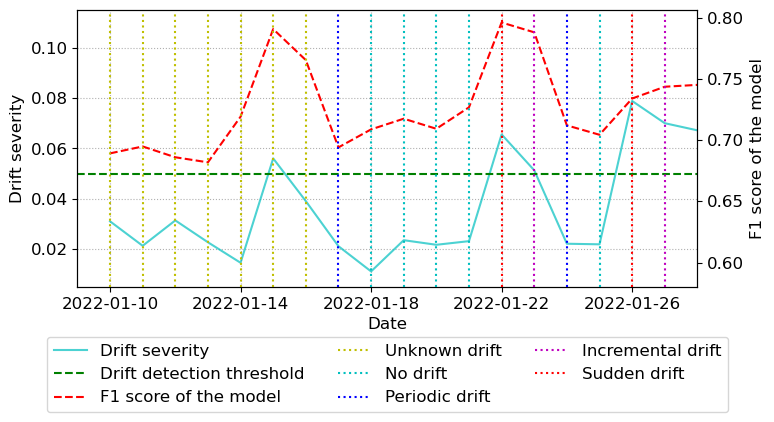

In [49]:
logs = logger_week.get_logs()
plt.rc('font', size=12)

fig = plt.figure(figsize = (8,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(logs.drift_strength, "c-", alpha = 0.7, label = "Drift severity")
ax.axhline(y = 0.05, color = 'g', linestyle = '--', label = "Drift detection threshold") 

ax2.plot(logs.f1, "r--", label = "F1 score of the model")
#ax2.legend(loc=2)
ax2.set_ylabel("F1 score of the model")

for date in logs[logs.Drift_type == "Unknown_drift"].index :
    ax2.axvline(x=date, color = 'y', linestyle = ':',label = "Unknown drift")
for date in logs[logs.Drift_type == "No_drift"].index :
    ax2.axvline(x=date, color = 'c', linestyle = ':',label = "No drift")
for date in logs[logs.Drift_type == "Periodic_drift"].index :
    ax2.axvline(x=date, color = 'b', linestyle = ':',label = "Periodic drift")
for date in logs[logs.Drift_type == "Incremental_drift"].index :
    ax2.axvline(x=date, color = 'm', linestyle = ':',label = "Incremental drift")
for date in logs[logs.Drift_type == "Sudden_drift"].index :
    ax2.axvline(x=date, color = 'r', linestyle = ':',label = "Sudden drift")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
handles, labels = ax2.get_legend_handles_labels()
by_label = by_label | dict(zip(labels, handles))

pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width, pos.height * 0.9])
ax.grid(linestyle=':')
ax.legend(
    by_label.values(),
    by_label.keys(),
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True,
    ncol=3, 
)

ax.set_ylabel("Drift severity")
ax.xaxis.set_major_locator(mdates.DayLocator(interval=4))
#ax.legend(loc=1)
ax.set_xlabel("Date")
ax.grid(linestyle=':')
ax.set_ylim((0.005,0.115))
plt.xlim((datetime(2022, 1, 9),datetime(2022, 1, 28)))
plt.show()


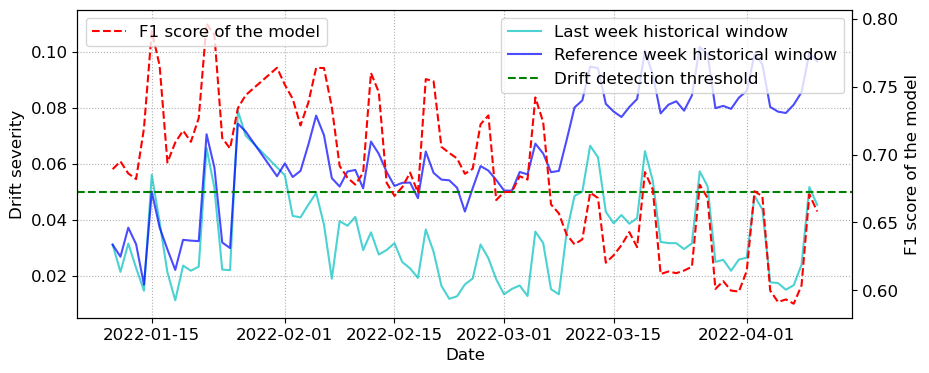

In [20]:
logs = logger_week.get_logs()
plt.rc('font', size=12)

fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.plot(logs.drift_strength, "c-", alpha = 0.7, label = "Last week historical window")
logs = logger_ref.get_logs()
ax.plot(logs.drift_strength, "b-", alpha = 0.7, label = "Reference week historical window")

ax.axhline(y = 0.05, color = 'g', linestyle = '--', label = "Drift detection threshold") 

ax2.plot(logs.f1, "r--", label = "F1 score of the model")
ax2.legend(loc=2)
ax2.set_ylabel("F1 score of the model")

ax.set_ylabel("Drift severity")
ax.legend(loc=1)
ax.set_xlabel("Date")
ax.grid(linestyle=':')
ax.set_ylim((0.005,0.115))
plt.show()
